In [1]:
import json
import pandas as pd
import glob
from datetime import date, timedelta
import openpyxl
import pathlib
import numpy as np
from datetime import datetime
import os
import re
import datetime
import xlsxwriter

In [2]:
#Regular / Appeal
Week_filter = {'W44','W45','W46','W47'}

In [3]:
from datetime import datetime
def convert_datetime(a):
    my_format="%Y-%m-%d %H:%M:%S"
    date_formats = ["%Y-%m-%d %H:%M:%S.%f", 
                    "%Y-%m-%d %H:%M:%S", 
                    "%m/%d/%Y %H:%M",
                    "%m-%d-%Y %H:%M", 
                    "%m/%d/%Y", 
                    "%Y-%m-%d", 
                    "%H:%M.%f",
                    "%m/%d/%Y %H:%M:%S"] 
    for fmt in date_formats:
        try:
            return datetime.strptime(str(a), fmt).strftime("%Y-%m-%d %H:%M:%S")
        except ValueError:
            pass
    try:
        return (datetime(1899, 12, 30) + timedelta(days=float(a))).strftime("%Y-%m-%d %H:%M:%S")
    except ValueError:
        pass
    if not re.match("\d+:\d+:\d+(\.\d+)?", str(a)):
        return str(a)
    return  
def convert_date(a):
    date_formats = ["%Y-%m-%d %H:%M:%S.%f", 
                    "%Y-%m-%d %H:%M:%S", 
                    "%m/%d/%Y %H:%M",
                    "%m-%d-%Y %H:%M", 
                    "%m/%d/%Y", 
                    "%Y-%m-%d", 
                    "%H:%M.%f",
                    "%m/%d/%Y %H:%M:%S"] 
    for fmt in date_formats:
        try:
            return datetime.strptime(str(a), fmt).strftime("%Y-%m-%d")
        except ValueError:
            pass
    try:
        return (datetime(1899, 12, 30) + timedelta(days=float(a))).strftime("%Y-%m-%d")
    except ValueError:
        pass
    if not re.match("\d+:\d+:\d+(\.\d+)?", str(a)):
        return str(a)
    return  

def input_data_csv( data_dir  ):
    data_dir = data_dir
    out_dir = '.'

    list_files = []
    for filename in pathlib.Path(data_dir).glob('**/*.csv'):
        list_files.append(filename)

    df1 = pd.concat(map(pd.read_csv, list_files),   ignore_index=True)
    return df1

def input_data_xlsx( data_dir  ):
    data_dir = data_dir
    out_dir = '.'

    list_files = []
    for filename in pathlib.Path(data_dir).glob('**/*.xlsx'):

        df=pd.concat(pd.read_excel(filename,sheet_name=None, skiprows=0))
        list_files.append(df)

    df1 = pd.concat(map(pd.read_excel, list_files),   ignore_index=True)
    
    return df1
def merge_csv_files(folder_path):
    file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
    dfs = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, dtype={'Queue ID': object,'object id':object,'BPO QA Task ID':object})
            df['source_file'] = os.path.basename(file_path)

            dfs.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
    merged_df = pd.concat(dfs, axis=0, ignore_index=True)
    return merged_df
def filter_time(df, column_name, from_date, to_date, selected_columns):
    filter_rawdata = df[(df[column_name].dt.strftime('%Y-%m-%d') >= from_date) & (df[column_name].dt.strftime('%Y-%m-%d') <= to_date)]
    filter_rawdata = filter_rawdata[selected_columns]
   
    return filter_rawdata

In [4]:
# Supporting 

#Queue
queue_list = pd.read_excel('Support_dashboard.xlsx',sheet_name='Queue List',dtype={'MOD QUEUE ID':object,'QA QUEUE ID':object})
queue_list = pd.DataFrame(queue_list)

#Week
week_list = pd.read_excel('Support_dashboard.xlsx',sheet_name='Week')

#Data full alternation
data_full_alternation = pd.read_excel('linemanager_full.xlsx')
data_full_alternation = data_full_alternation[data_full_alternation['Role'].str.contains('Operator')]
data_full_alternation = data_full_alternation[['EffectDate','Email','LineManager','Task','ProductionTenure']]

aliases_final_decision = {"Failed appeal":['failed appeal','mod wrong','mods wrong'] ,
            "Edge case":['edge case', 'borderline'],
            "Appeal successfully":['appeal successfully','qa wrong','qas wrong','mod correct'],
            }

In [5]:
#Regular_appeal_rawdata_diff_case

regular_appeal_Rawdata = merge_csv_files('Regular_appeal')
regular_appeal_Rawdata = regular_appeal_Rawdata[~regular_appeal_Rawdata['Queue Name'].isnull()]
print(regular_appeal_Rawdata.columns)
regular_appeal_Rawdata['mod_date'] = pd.to_datetime(regular_appeal_Rawdata['mod_date'].apply(convert_date))
regular_appeal_Rawdata['BPO QA Date'] = pd.to_datetime(regular_appeal_Rawdata['BPO QA Date'].apply(convert_date))
regular_appeal_Rawdata['Final Decision'] = regular_appeal_Rawdata['Final Decision'].fillna('Mod correct')
for k, v in aliases_final_decision.items():
    pat = '|'.join(v)
    regular_appeal_Rawdata.loc[regular_appeal_Rawdata['Final Decision'].str.contains(pat, case=False),'Final Decision'] = k
BPO_QA_Decision_keep_values = ['Failed appeal', 'Appeal successfully', 'Edge case','Mod correct']
temp_col = regular_appeal_Rawdata['Final Decision'].copy()
temp_col[~temp_col.isin(BPO_QA_Decision_keep_values)] = 'Failed appeal'
regular_appeal_Rawdata['Final Decision'] = temp_col
regular_appeal_diff_cases = regular_appeal_Rawdata[(regular_appeal_Rawdata['Final Decision']=="Failed appeal")]
regular_appeal_diff_cases = regular_appeal_diff_cases.sort_values(by=['mod_date'],ascending=True)
regular_appeal_diff_cases

Index(['Reported Week', 'Compound', 'Queue Name', 'Queue ID', 'mod', 'TL',
       'mod_date', 'object id', 'mod_result', 'mod_reason', 'mod_aht',
       'BPO QA', 'BPO QA Date', 'BPO QA Task ID', 'BPO QA Link',
       'BPO QA Result', 'BPO QA Reason', 'Diff case', 'To be appeal (Y/N)',
       '[TL Remarks]', 'BPO QA Handler', 'Final Decision', 'Final False Error',
       'Policy Error', 'Error Category 1', 'Error Category 2',
       'Error Category 3', 'Mod RCA from Rock', 'Remark', 'Screenshot',
       '[BD] QA Handler', 'BD QA Agree/Disagree', 'BD QA Approve/ Reject',
       'BD QA Decision', 'Final False Error.1', 'Wrong Tagging',
       '[BD] Comments', 'Screenshot.1', 'Policy screenshot', 'source_file',
       'Month', 'Date & Time Dump', '[BD] Remarks', 'Policy Screenshot',
       'Date', 'RCA lv1', 'RCA lv2', 'RCA lv3', 'Policy Error.1',
       'Policy error', 'Policy error_1', 'Policy error_2', 'Final_False_Error',
       'Wrong_Tagging', 'LineManager', '#REF!', '#REF!.1', '#RE

,Reported Week,Compound,Queue Name,Queue ID,mod,TL,mod_date,object id,mod_result,mod_reason,...,Policy error_2,Final_False_Error,Wrong_Tagging,LineManager,#REF!,#REF!.1,#REF!.2,#REF!.3,#REF!.4,#REF!.5
4,W1 (12.31 - 01.06),IPR,QA VN LL Anchor Video Counterfeit Key Frame,NaN,hieu.ntn@trans-cosmos.com.vn,NaN,2022-12-21,7179025248732447233,Approve,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,W1 (12.31 - 01.06),IPR,QA VN LL Anchor Video Counterfeit Key Frame,NaN,do.nd@trans-cosmos.com.vn,NaN,2022-12-21,7178967893550301697,Disapprove,Creator -> Misleading Brand,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,W1 (12.31 - 01.06),IPR,QA VN LL Anchor Video Counterfeit Key Frame,NaN,phuong.tlm@trans-cosmos.com.vn,NaN,2022-12-22,7179436239890678273,Disapprove,Product -> Counterfeit Products -> Abnormal pr...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,W1 (12.31 - 01.06),IPR,QA VN LL Anchor Video Counterfeit Key Frame,NaN,thu.nta2@trans-cosmos.com.vn,NaN,2022-12-22,7179406272440107522,Approve,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,W1 (12.31 - 01.06),IPR,QA VN LL Anchor Video Counterfeit Key Frame,NaN,thu.dta3@trans-cosmos.com.vn,NaN,2022-12-22,7179457394999558657,Approve,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62305,W48 (11.26 - 12.02),CB Product,[QA] VN CB Product Initial Review 02,7.14128E+18,hoang.tt@trans-cosmos.com.vn,NaN,2023-11-28,1.72983E+18,Approve,NaN,...,---,NaN,NaN,CHẾ MINH HẢI,NaN,NaN,NaN,NaN,NaN,NaN
62314,W48 (11.26 - 12.02),Seller,QA VN LL Shop Logo,7.1617E+18,vi.llt@trans-cosmos.com.vn,NaN,2023-11-28,3589394222,Approve,NaN,...,---,NaN,NaN,NGUYỄN THỊ THU TRINH,NaN,NaN,NaN,NaN,NaN,NaN
62313,W48 (11.26 - 12.02),CB Product,[QA]VN CB Product Buffer,7.12754E+18,ngan.ltt@trans-cosmos.com.vn,NaN,2023-11-28,1.72983E+18,Approve,NaN,...,---,NaN,NaN,NGUYỄN TUẤN VĂN,NaN,NaN,NaN,NaN,NaN,NaN
62322,W48 (11.26 - 12.02),Livestream,[QA] VN LL Live 02,7.14128E+18,chung.nd@trans-cosmos.com.vn,NaN,2023-11-28,7306498729455012615_1701178132,Not Approve,misleading functionality and effect,...,---,NaN,NaN,NGUYỄN THỊ TUYẾT NHUNG,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
high_risk_rca = ['misinterpretation', 'knowledge gap', 'negligence']
high_risk_table = regular_appeal_diff_cases[['Reported Week', 'Compound', 'Queue Name', 'mod','mod_date','Error Category 1', 'Error Category 2','Error Category 3']]

for rca in high_risk_rca:
    high_risk_table[rca] = 0

high_risk_table['Error Category 1'] = high_risk_table['Error Category 1'].str.lower()
high_risk_table['Error Category 2'] = high_risk_table['Error Category 2'].str.lower()
high_risk_table['Error Category 3'] = high_risk_table['Error Category 3'].str.lower()

for index, row in high_risk_table.iterrows():
    error_category_2 = row['Error Category 2']
    if isinstance(error_category_2, str):
        for rca in high_risk_rca:
            if rca in error_category_2:
                high_risk_table.at[index, rca] = 1

high_risk_table = high_risk_table.drop(['Error Category 1', 'Error Category 2', 'Error Category 3'], axis=1)

error_factors = {'misinterpretation': 2, 'knowledge gap': 1, 'negligence': 3}

high_risk_table_with_factors = high_risk_table.copy()

# create new columns with the factored values
for error_type, factor in error_factors.items():
    high_risk_table_with_factors[error_type + '_score'] = high_risk_table_with_factors[error_type] * factor

# select the columns we want to keep
high_risk_table = high_risk_table_with_factors[['Reported Week', 'Compound', 'Queue Name', 'mod', 'mod_date', 'misinterpretation', 'knowledge gap', 'negligence', 'misinterpretation_score', 'knowledge gap_score', 'negligence_score']]
high_risk_table = high_risk_table.groupby(['Reported Week', 'Compound', 'Queue Name', 'mod', 'mod_date']).agg({
    'misinterpretation': 'sum',
    'knowledge gap': 'sum',
    'negligence': 'sum',
    'misinterpretation_score': 'sum',
    'knowledge gap_score': 'sum',
    'negligence_score': 'sum'
}).reset_index()
high_risk_table


C:\Users\v6210227\AppData\Local\Temp\ipykernel_14116\1142307027.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_risk_table[rca] = 0
C:\Users\v6210227\AppData\Local\Temp\ipykernel_14116\1142307027.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_risk_table[rca] = 0
C:\Users\v6210227\AppData\Local\Temp\ipykernel_14116\1142307027.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,Reported Week,Compound,Queue Name,mod,mod_date,misinterpretation,knowledge gap,negligence,misinterpretation_score,knowledge gap_score,negligence_score
0,W1 (12.31 - 01.06),Anchor Video,[QA] VN LL Anchor Video 02,\nhuong.ntt2@trans-cosmos.com.vn,2023-01-06,1,0,0,2,0,0
1,W1 (12.31 - 01.06),Anchor Video,[QA] VN LL Anchor Video 02,dung.ltm@trans-cosmos.com.vn,2023-01-02,0,1,0,0,1,0
2,W1 (12.31 - 01.06),Anchor Video,[QA] VN LL Anchor Video 02,dung.ltm@trans-cosmos.com.vn,2023-01-03,1,0,0,2,0,0
3,W1 (12.31 - 01.06),Anchor Video,[QA] VN LL Anchor Video 02,duong.dth1@trans-cosmos.com.vn,2023-01-02,0,0,1,0,0,3
4,W1 (12.31 - 01.06),Anchor Video,[QA] VN LL Anchor Video 02,duy.cnp@trans-cosmos.com.vn,2023-01-01,0,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
16494,W9 (02.25 - 03.03),Seller,[QA]VN LL Seller On Boarding,thu.vtt@trans-cosmos.com.vn,2023-02-28,1,0,0,2,0,0
16495,W9 (02.25 - 03.03),Seller,[QA]VN LL Seller On Boarding,toan.qk@trans-cosmos.com.vn,2023-03-03,0,0,1,0,0,3
16496,W9 (02.25 - 03.03),Seller,[QA]VN LL Seller On Boarding,trang.dtt1@trans-cosmos.com.vn,2023-03-02,1,0,0,2,0,0
16497,W9 (02.25 - 03.03),Seller,[QA]VN LL Seller On Boarding,trang.gt@trans-cosmos.com.vn,2023-02-25,0,0,1,0,0,3


In [7]:
samples_ppe = input_data_csv("Sample Size All Queues/All")
false_ppe = input_data_csv("False case All Queues/All")

samples_ppe['Moderation Date'] = pd.to_datetime(samples_ppe['Moderation Date'].apply(convert_date))
false_ppe['Moderation Date'] = pd.to_datetime(false_ppe['Moderation Date'].apply(convert_date))

In [8]:
compound_filter = ['Anchor Video','Livestream','CB Product','LL Product','Seller','IPR','Appeal']
mod_accr_overall = pd.merge(samples_ppe,false_ppe,how='left',
                            left_on=['Week', 'Moderation Date', 'Queue Name', 'Moderators Name'],
                            right_on=['Week', 'Moderation Date', 'Queue Name', 'Moderators Name'])
mod_accr_overall['Mods Wrong'] = mod_accr_overall['Mods Wrong'].fillna(0)              
mod_accr_overall_copy = pd.merge(mod_accr_overall,queue_list,how='left',left_on='Queue Name',right_on='QA QUEUE NAME')
mod_accr_overall_copy = mod_accr_overall_copy[['Week', 'Moderation Date','CATEGORY','COMPOUND', 'QA QUEUE NAME', 'Moderators Name','Sample Size','Mods Wrong']]
mod_accr_overall_copy[mod_accr_overall_copy['Week'].isnull()]
mod_accr_overall_copy = mod_accr_overall_copy[mod_accr_overall_copy['COMPOUND'].isin(compound_filter)]
mod_accr_overall_copy = mod_accr_overall_copy.sort_values(by='Moderation Date',ascending=True)

In [9]:
mod_accr_overall_linemanager = mod_accr_overall_copy[['Moderation Date','QA QUEUE NAME','Moderators Name','Sample Size','Mods Wrong']]
mod_accr_overall_linemanager = pd.merge(mod_accr_overall_linemanager,data_full_alternation,how='left',left_on=['Moderation Date','Moderators Name'],right_on=['EffectDate','Email'])
mod_accr_overall_linemanager = pd.merge(mod_accr_overall_linemanager,week_list,how='left',left_on='Moderation Date',right_on='Date').rename(columns={'Mod_Week':'Week'})
mod_accr_overall_linemanager = pd.merge(mod_accr_overall_linemanager,queue_list,how='left',left_on='QA QUEUE NAME',right_on='QA QUEUE NAME')
mod_accr_overall_linemanager = mod_accr_overall_linemanager.dropna(subset=['LineManager', 'Report_Week'])
mod_accr_overall_linemanager = mod_accr_overall_linemanager[['Quarter','Month','Week','Moderation Date',
                                                             'COMPOUND','QA QUEUE NAME','EffectDate','Moderators Name','LineManager','Task',
                                                             'ProductionTenure','Sample Size','Mods Wrong']]


mod_accr_overall_linemanager = mod_accr_overall_linemanager.drop_duplicates()

mod_accr_overall_linemanager['Shift'] = None
mod_accr_overall_linemanager['Main/Cross'] = None

mod_accr_overall_linemanager['Shift'] = np.where(mod_accr_overall_linemanager['Task'].str.contains('_ds'), 'Day Shift', mod_accr_overall_linemanager['Shift'])
mod_accr_overall_linemanager['Shift'] = np.where(mod_accr_overall_linemanager['Task'].str.contains('_ns'), 'Night Shift', mod_accr_overall_linemanager['Shift'])
mod_accr_overall_linemanager['Shift'] = np.where(mod_accr_overall_linemanager['Shift'].isnull(), 'Day Shift', mod_accr_overall_linemanager['Shift'])

conditions_queue_group = [
    mod_accr_overall_linemanager['COMPOUND'].str.contains('Product|Seller', na=False),
    mod_accr_overall_linemanager['COMPOUND'].str.contains('Anchor|Live', na=False),
    mod_accr_overall_linemanager['COMPOUND'].str.contains('IPR', na=False),
    mod_accr_overall_linemanager['COMPOUND'].str.contains('Appeal', na=False)
]
values_queue_group = [1, 2, 3, 0]
mod_accr_overall_linemanager['Q_Group'] = np.select(conditions_queue_group, values_queue_group, default=None)

conditions_queue_group = [
    mod_accr_overall_linemanager['COMPOUND'].str.contains('Product|Seller', na=False),
    mod_accr_overall_linemanager['COMPOUND'].str.contains('Anchor|Live', na=False),
    mod_accr_overall_linemanager['COMPOUND'].str.contains('IPR', na=False),
    mod_accr_overall_linemanager['COMPOUND'].str.contains('Appeal', na=False)
]
values_queue_group = [1, 2, 3, 0]
mod_accr_overall_linemanager['Q_Group'] = np.select(conditions_queue_group, values_queue_group, default=None)

conditions_mod_group = [
    mod_accr_overall_linemanager['Task'].str.contains('Product|Seller', na=False),
    mod_accr_overall_linemanager['Task'].str.contains('Anchor|Live', na=False),
    mod_accr_overall_linemanager['Task'].str.contains('Counterfeit', na=False),
    mod_accr_overall_linemanager['Task'].str.contains('Appeal', na=False),
    mod_accr_overall_linemanager['Task'].str.contains('Trooper', na=False)
]
values_mod_group = [1, 2, 3, 0, 4]
mod_accr_overall_linemanager['M_Group'] = np.select(conditions_mod_group, values_mod_group, default=None)

mod_accr_overall_linemanager['Main/Cross'] = np.where(
   mod_accr_overall_linemanager['Q_Group'] == mod_accr_overall_linemanager['M_Group'], 
   'Main Task', 
   mod_accr_overall_linemanager['Main/Cross'])
mod_accr_overall_linemanager['Main/Cross'] = np.where(
   (mod_accr_overall_linemanager['M_Group'] == 4) & 
   (mod_accr_overall_linemanager['COMPOUND'].str.contains('Product|Anchor')), 
   'Main Task', 
   mod_accr_overall_linemanager['Main/Cross'])
mod_accr_overall_linemanager['Main/Cross'] = np.where(
    (mod_accr_overall_linemanager['QA QUEUE NAME'].str.contains('Counterfeit')) &
    (mod_accr_overall_linemanager['QA QUEUE NAME'].str.contains('Appeal')) &
    (mod_accr_overall_linemanager['M_Group'] == 3),
    'Main Task',
    mod_accr_overall_linemanager['Main/Cross']
)
mod_accr_overall_linemanager['Main/Cross'] = np.where(
   mod_accr_overall_linemanager['Main/Cross'].isnull(), 
   'Cross Support', 
   mod_accr_overall_linemanager['Main/Cross'])

mod_accr_overall_linemanager.loc[mod_accr_overall_linemanager['ProductionTenure'] >= 90, 'Seniority'] = 'oldbie'
mod_accr_overall_linemanager.loc[mod_accr_overall_linemanager['ProductionTenure'] < 90, 'Seniority'] = 'newbie'

high_risk_table = high_risk_table.rename(columns={
    'Reported Week': 'Week',
    'mod_date': 'Moderation Date',
    'Compound': 'COMPOUND',
    'Queue Name': 'QA QUEUE NAME',
    'mod': 'Moderators Name'
})

print(high_risk_table.columns)

mod_accr_overall_linemanager = pd.merge(mod_accr_overall_linemanager, high_risk_table, how='left', on=['Week', 'Moderation Date', 'COMPOUND', 'QA QUEUE NAME', 'Moderators Name'])

mod_accr_overall_linemanager['misinterpretation'].fillna(0, inplace=True)
mod_accr_overall_linemanager['knowledge gap'].fillna(0, inplace=True)
mod_accr_overall_linemanager['negligence'].fillna(0, inplace=True)

mod_accr_overall_linemanager.insert(18, 'Risk Score', mod_accr_overall_linemanager['misinterpretation_score'] + mod_accr_overall_linemanager['knowledge gap_score'] + mod_accr_overall_linemanager['negligence_score'])
mod_accr_overall_linemanager = mod_accr_overall_linemanager.fillna(0)

mod_accr_overall_linemanager = mod_accr_overall_linemanager[mod_accr_overall_linemanager['Week'].str.contains('|'.join(Week_filter))]
mod_accr_overall_linemanager.to_excel('PPE/PPE.xlsx', index=False)
mod_accr_overall_linemanager

C:\Users\v6210227\AppData\Local\Temp\ipykernel_14116\3637215891.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'oldbie' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mod_accr_overall_linemanager.loc[mod_accr_overall_linemanager['ProductionTenure'] >= 90, 'Seniority'] = 'oldbie'


Index(['Week', 'COMPOUND', 'QA QUEUE NAME', 'Moderators Name',
       'Moderation Date', 'misinterpretation', 'knowledge gap', 'negligence',
       'misinterpretation_score', 'knowledge gap_score', 'negligence_score'],
      dtype='object')


,Quarter,Month,Week,Moderation Date,COMPOUND,QA QUEUE NAME,EffectDate,Moderators Name,LineManager,Task,...,Q_Group,M_Group,Seniority,Risk Score,misinterpretation,knowledge gap,negligence,misinterpretation_score,knowledge gap_score,negligence_score
278273,4.0,11.0,W44 (10.29 - 11.04),2023-10-29,Anchor Video,[QA] VN LL Anchor Video High VV 02,2023-10-29,thuong.lth1@trans-cosmos.com.vn,TRẦN ANH QUÂN,Anchor_ds,...,2,2,oldbie,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278274,4.0,11.0,W44 (10.29 - 11.04),2023-10-29,Anchor Video,[QA] VN LL Anchor Video High VV 02,2023-10-29,thoa.htk@trans-cosmos.com.vn,PHẠM NGỌC KIM LONG,Anchor_ds,...,2,2,oldbie,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278275,4.0,11.0,W44 (10.29 - 11.04),2023-10-29,Anchor Video,[QA] VN LL Anchor Video High VV 02,2023-10-29,thinh.ld@trans-cosmos.com.vn,NGUYỄN THANH PHI,Trooper_ds,...,2,4,oldbie,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278276,4.0,11.0,W44 (10.29 - 11.04),2023-10-29,Anchor Video,[QA] VN LL Anchor Video High VV 02,2023-10-29,the.ltm@trans-cosmos.com.vn,NGUYỄN QUANG ANH,Anchor_ds,...,2,2,oldbie,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278277,4.0,11.0,W44 (10.29 - 11.04),2023-10-29,Anchor Video,[QA] VN LL Anchor Video High VV 02,2023-10-29,thao.ltt2@trans-cosmos.com.vn,LÊ TẤN THỊNH,Anchor_ds,...,2,2,oldbie,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311669,4.0,11.0,W47 (11.19 - 11.25),2023-11-25,Appeal,QA [VN][Product Counterfeit]Appeal Audit,2023-11-25,do.nd@trans-cosmos.com.vn,NGUYỄN XUÂN ĐẠT,Counterfeit_ns,...,0,3,oldbie,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311670,4.0,11.0,W47 (11.19 - 11.25),2023-11-25,Appeal,QA [VN][Product Counterfeit]Appeal Audit,2023-11-25,dieu.dth@trans-cosmos.com.vn,NGUYỄN XUÂN ĐẠT,Counterfeit_ns,...,0,3,oldbie,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311671,4.0,11.0,W47 (11.19 - 11.25),2023-11-25,Appeal,QA [VN][Product Counterfeit]Appeal Audit,2023-11-25,bang.pt@trans-cosmos.com.vn,HOÀNG THỊ YẾN,Counterfeit_ds,...,0,3,oldbie,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311672,4.0,11.0,W47 (11.19 - 11.25),2023-11-25,Appeal,QA [VN][Product Counterfeit]Appeal Audit,2023-11-25,nghia.tt@trans-cosmos.com.vn,HOÀNG THỊ YẾN,Counterfeit_ds,...,0,3,oldbie,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
import numpy as np
import statistics

cp_deepdive = mod_accr_overall_linemanager[(mod_accr_overall_linemanager['Mods Wrong'] > 0) & (mod_accr_overall_linemanager['Week'].str.contains('W45'))][['COMPOUND', 'Moderators Name', 'Mods Wrong']]
compound_stats = cp_deepdive.groupby(by=['COMPOUND', 'Moderators Name'], as_index=False).agg({'Mods Wrong': 'sum'})
compound_stats.sort_values(by=['Mods Wrong'], ascending=False)

# Tạo DataFrame trống để chứa kết quả cuối cùng
final_df = pd.DataFrame(columns=['COMPOUND', 'Mean', 'Median', 'Mode', 'Min', 'Max', 'Standard Deviation'])

# Duyệt qua từng COMPOUND
unique_compounds = compound_stats['COMPOUND'].unique()
for compound in unique_compounds:
    data = compound_stats[compound_stats['COMPOUND'] == compound]['Mods Wrong']
    
    mean = data.mean()
    median = data.median()
    mode = statistics.mode(data) if len(data) > 0 else None
    min_val = data.min()
    max_val = data.max()
    std_dev = data.std()
    
    final_df = pd.concat([final_df, pd.DataFrame({'COMPOUND': [compound], 'Mean': [mean], 'Median': [median], 'Mode': [mode], 'Min': [min_val], 'Max': [max_val], 'Standard Deviation': [std_dev]})], ignore_index=True)
final_df.to_excel('PPE/histogram table.xlsx',index=False)

C:\Users\v6210227\AppData\Local\Temp\ipykernel_14116\3603896442.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, pd.DataFrame({'COMPOUND': [compound], 'Mean': [mean], 'Median': [median], 'Mode': [mode], 'Min': [min_val], 'Max': [max_val], 'Standard Deviation': [std_dev]})], ignore_index=True)


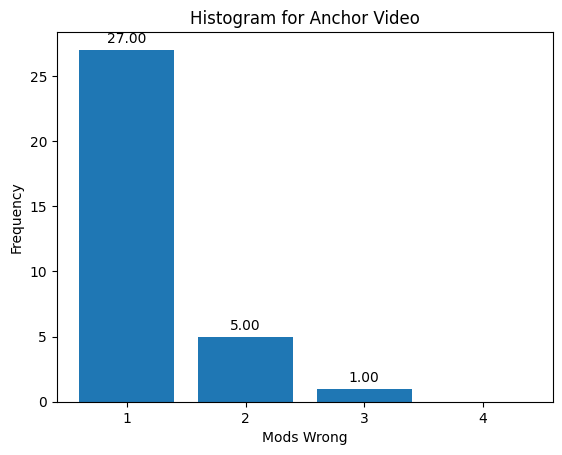

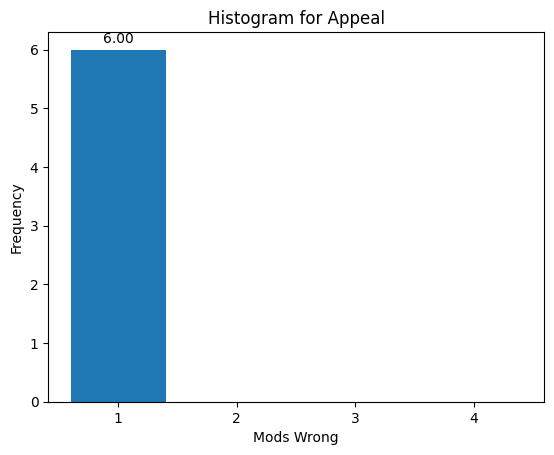

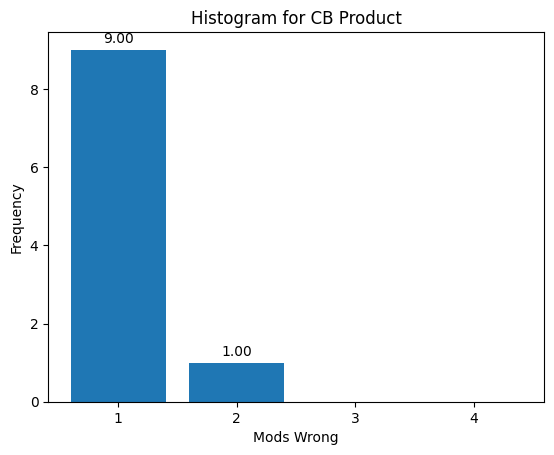

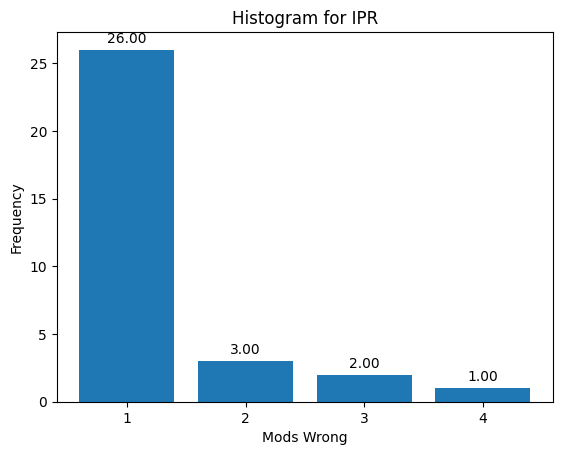

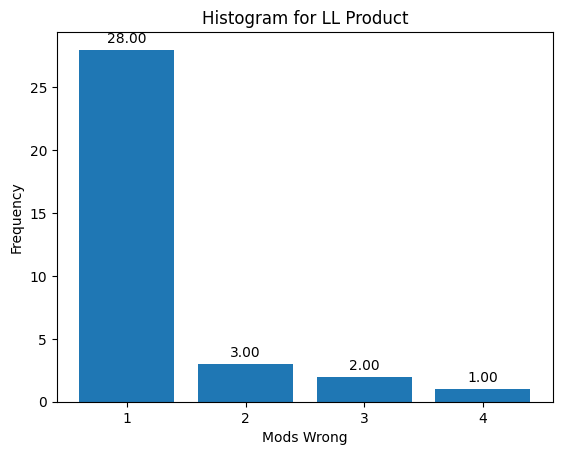

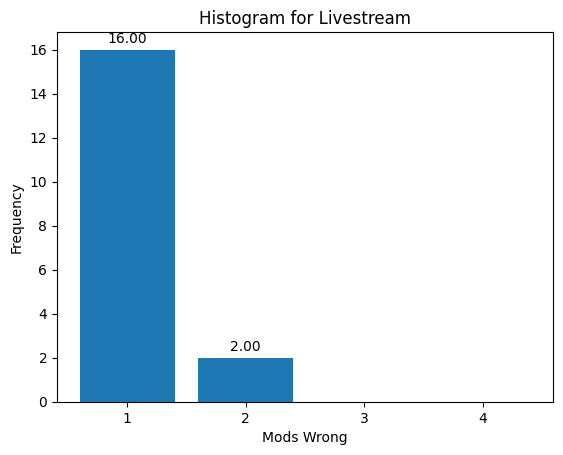

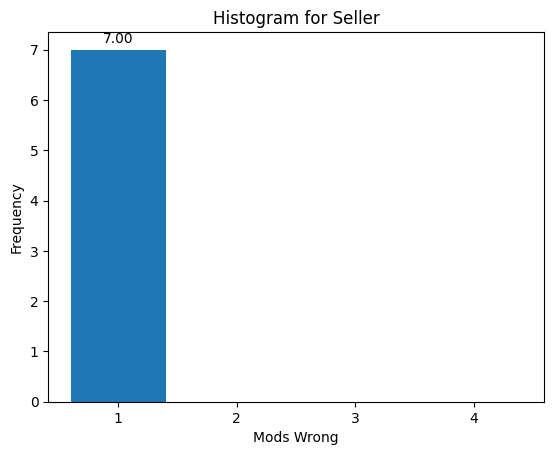

In [11]:
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from matplotlib.ticker import FuncFormatter
import os

filtered_data = compound_stats[['COMPOUND', 'Moderators Name', 'Mods Wrong']]

wb = Workbook()

Min = filtered_data['Mods Wrong'].min()
Max = filtered_data['Mods Wrong'].max()

grouped = filtered_data.groupby('COMPOUND')

def save_histogram_as_image(data, name, Min, Max):
    hist, bins = np.histogram(data, bins=range(Min, Max + 2))
    fig, ax = plt.subplots()
    ax.bar(range(Min, Max + 1), hist, width=0.8)
    ax.set_title(f'Histogram for {name}')
    ax.set_xlabel('Mods Wrong')
    ax.set_ylabel('Frequency')
    ax.set_xticks(range(Min, Max + 1))
    
    for i, rect in enumerate(ax.containers[0]):
        height = rect.get_height()
        if height > 0:
            ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points", ha='center', color='black')

    img_path = f'{name}_hist.png'
    plt.savefig(img_path, format='png')
    return img_path

if not os.path.exists('temp_images'):
    os.makedirs('temp_images')

for name, group in grouped:
    compound_data = group['Mods Wrong']
    img_path = save_histogram_as_image(compound_data, name, Min, Max)

    sheet = wb.create_sheet(title=name)

    img = Image(img_path)
    img.anchor = 'A2'
    sheet.add_image(img)

wb.save('PPE/histogram.xlsx')

for file in os.listdir('temp_images'):
    file_path = os.path.join('temp_images', file)
    os.remove(file_path)

os.rmdir('temp_images')

In [12]:
mod_accr_overall_linemanager.columns

Index(['Quarter', 'Month', 'Week', 'Moderation Date', 'COMPOUND',
       'QA QUEUE NAME', 'EffectDate', 'Moderators Name', 'LineManager', 'Task',
       'ProductionTenure', 'Sample Size', 'Mods Wrong', 'Shift', 'Main/Cross',
       'Q_Group', 'M_Group', 'Seniority', 'Risk Score', 'misinterpretation',
       'knowledge gap', 'negligence', 'misinterpretation_score',
       'knowledge gap_score', 'negligence_score'],
      dtype='object')

In [13]:
mod_accr_overall_linemanager_copy = mod_accr_overall_linemanager.copy()
mod_accr_overall_linemanager.loc[mod_accr_overall_linemanager['COMPOUND'].isin(['LL Product', 'CB Product']), 'COMPOUND'] = 'Product'


mod_accr_overall_linemanager_accr = mod_accr_overall_linemanager.groupby(by=['Week','COMPOUND', 'LineManager'],as_index=False).agg({'Sample Size':'sum','Mods Wrong':'sum','Risk Score':'sum'})
mod_accr_overall_accr = mod_accr_overall_linemanager_copy.groupby(by=['Week','COMPOUND'],as_index=False).agg({'Sample Size':'sum','Mods Wrong':'sum','Risk Score':'sum'})
mod_accr_overall_accr_shift = mod_accr_overall_linemanager_copy.groupby(by=['Week','COMPOUND','Shift'],as_index=False).agg({'Sample Size':'sum','Mods Wrong':'sum','Risk Score':'sum'})

mod_accr_overall_linemanager_accr['%Accr'] = 1 - (mod_accr_overall_linemanager_accr['Mods Wrong'] / mod_accr_overall_linemanager_accr['Sample Size'])
mod_accr_overall_accr['%Accr'] = 1 - (mod_accr_overall_accr['Mods Wrong'] / mod_accr_overall_accr['Sample Size'])
mod_accr_overall_accr_shift['%Accr'] = 1 - (mod_accr_overall_accr_shift['Mods Wrong'] / mod_accr_overall_accr_shift['Sample Size'])

mod_accr_overall_linemanager_accr['COMPOUND'].unique()

array(['Anchor Video', 'Appeal', 'IPR', 'Livestream', 'Product', 'Seller'],
      dtype=object)

In [14]:
mod_accr_overall_accr

,Week,COMPOUND,Sample Size,Mods Wrong,Risk Score,%Accr
0,W44 (10.29 - 11.04),Anchor Video,3940.0,32,76.0,0.991878
1,W44 (10.29 - 11.04),Appeal,5945.0,8,17.0,0.998654
2,W44 (10.29 - 11.04),CB Product,2623.0,13,26.0,0.995044
3,W44 (10.29 - 11.04),IPR,5925.0,42,113.0,0.992911
4,W44 (10.29 - 11.04),LL Product,6433.0,50,119.0,0.992228
5,W44 (10.29 - 11.04),Livestream,2547.0,18,40.0,0.992933
6,W44 (10.29 - 11.04),Seller,2414.0,11,28.0,0.995443
7,W45 (11.05 - 11.11),Anchor Video,4175.0,40,86.0,0.990419
8,W45 (11.05 - 11.11),Appeal,5860.0,6,13.0,0.998976
9,W45 (11.05 - 11.11),CB Product,2653.0,11,27.0,0.995854


In [15]:
if not os.path.exists("PPE"):
    os.mkdir("PPE")

mod_accr_overall_linemanager_accr_chart = mod_accr_overall_linemanager_accr[['Week','COMPOUND', 'LineManager','Risk Score', '%Accr']]
mod_accr_overall_accr_chart = mod_accr_overall_accr[['Week','COMPOUND','Risk Score', '%Accr']]
data = mod_accr_overall_linemanager_accr_chart
unique_compounds = data['COMPOUND'].unique()
max_risk_score = data['Risk Score'].max()

for compound in unique_compounds:
    compound_data = mod_accr_overall_linemanager_accr[mod_accr_overall_linemanager_accr['COMPOUND'] == compound]
    line_managers = compound_data['LineManager'].unique()

    compound_folder = os.path.join("PPE", compound)
    os.makedirs(compound_folder, exist_ok=True)

    wb = Workbook()

    for line_manager in line_managers:
        sheet = wb.create_sheet(title=line_manager)

        manager_data = compound_data[compound_data['LineManager'] == line_manager]

        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax2 = ax1.twinx()

        bar = ax1.bar(manager_data['Week'], manager_data['Risk Score'], color='#42606A', label='Risk Score')
        ax1.set_xlabel('Week')
        ax1.set_ylabel('Risk Score', color='b')

        line = ax2.plot(manager_data['Week'], manager_data['%Accr'], color='#EE1D52', marker='o', label='%Accr')
        ax2.set_ylabel('%Accr', color='r')

        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')
        fig.set_size_inches(10, 6)
        ax1.set_ylim(0, max_risk_score)
        ax2.set_ylim(0.8, 1.05)
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

        plt.title(f'{compound} - {line_manager}')

        for i, rect in enumerate(ax1.containers[0]):
            height = rect.get_height()
            ax1.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, -10), textcoords="offset points", ha='center', color='white')
        for i, line in enumerate(ax2.lines):
            for x, y in zip(line.get_xdata(), line.get_ydata()):
                ax2.annotate(f'{y:.2%}', xy=(x, y), xytext=(0, 3), textcoords="offset points", ha='center')

        img_path = os.path.join(compound_folder, f"{line_manager}_chart.png")
        plt.savefig(img_path, dpi=100)
        img = Image(img_path)
        sheet.add_image(img, 'E5')
        plt.close()

        sheet.append(['Week', 'Risk Score', '%Accr'])
        for index, row in manager_data.iterrows():
            sheet.append([row['Week'], row['Risk Score'], row['%Accr']])

    del wb['Sheet']

    excel_file = os.path.join("PPE", f"{compound}_Performance_Chart_All_Managers.xlsx")
    wb.save(excel_file)


In [ ]:
if not os.path.exists("PPE"):
    os.mkdir("PPE")

mod_accr_overall_linemanager_accr_chart = mod_accr_overall_accr[['Week', 'COMPOUND', 'Risk Score', '%Accr']]
data = mod_accr_overall_linemanager_accr_chart
unique_compounds = data['COMPOUND'].unique()

max_risk_scores = []

wb_all_compounds = Workbook()
for compound in unique_compounds:
    compound_data = mod_accr_overall_accr[mod_accr_overall_accr['COMPOUND'] == compound]

    sheet = wb_all_compounds.create_sheet(title=compound)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    bar = ax1.bar(compound_data['Week'], compound_data['Risk Score'], color='#42606A', label='Risk Score')
    ax1.set_xlabel('Week')
    ax1.set_ylabel('Risk Score', color='b')

    line = ax2.plot(compound_data['Week'], compound_data['%Accr'], color='#EE1D52', marker='o', label='%Accr')
    ax2.set_ylabel('%Accr', color='r')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    fig.set_size_inches(10, 6)
    max_risk_score_compound = compound_data['Risk Score'].max() + 100
    ax1.set_ylim(0, max_risk_score_compound)
    ax2.set_ylim(0.8, 1.05)
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    plt.title(f'{compound}')

    for i, rect in enumerate(ax1.containers[0]):
        height = rect.get_height()
        ax1.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, -10), textcoords="offset points", ha='center', color='white')
    for i, line in enumerate(ax2.lines):
        for x, y in zip(line.get_xdata(), line.get_ydata()):
            ax2.annotate(f'{y:.2%}', xy=(x, y), xytext=(0, 3), textcoords="offset points", ha='center')

    img_path = os.path.join("PPE", f"{compound}_chart.png")
    plt.savefig(img_path, dpi=100)
    img = Image(img_path)
    sheet.add_image(img, 'E5')
    plt.close()

    sheet.append(['Week', 'Risk Score', '%Accr'])
    for index, row in compound_data.iterrows():
        sheet.append([row['Week'], row['Risk Score'], row['%Accr']])

excel_file_all_compounds = os.path.join("PPE", "All_Compounds_Performance_Charts.xlsx")
wb_all_compounds.save(excel_file_all_compounds)

In [ ]:
if not os.path.exists("PPE"):
    os.mkdir("PPE")

mod_accr_overall_accr_chart_shift = mod_accr_overall_accr_shift[['Week', 'COMPOUND', 'Shift', 'Risk Score', '%Accr']]
data_shift = mod_accr_overall_accr_chart_shift
unique_compounds_shift = data_shift['COMPOUND'].unique()
unique_shifts = data_shift['Shift'].unique()

wb_all_compounds_shift = Workbook()
for compound in unique_compounds_shift:
    for shift in unique_shifts:
        compound_shift_data = mod_accr_overall_accr_chart_shift[
            (mod_accr_overall_accr_chart_shift['COMPOUND'] == compound) &
            (mod_accr_overall_accr_chart_shift['Shift'] == shift)
        ]

        if not compound_shift_data.empty:
            sheet_title = f"{compound}_{shift}"
            sheet = wb_all_compounds_shift.create_sheet(title=sheet_title)

            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax2 = ax1.twinx()

            bar = ax1.bar(compound_shift_data['Week'], compound_shift_data['Risk Score'], color='#42606A', label='Risk Score')
            ax1.set_xlabel('Week')
            ax1.set_ylabel('Risk Score', color='b')

            line = ax2.plot(compound_shift_data['Week'], compound_shift_data['%Accr'], color='#EE1D52', marker='o', label='%Accr')
            ax2.set_ylabel('%Accr', color='r')

            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels + labels2, loc='upper left')
            fig.set_size_inches(10, 6)
            max_risk_score_compound_shift = compound_shift_data['Risk Score'].max() + 100
            ax1.set_ylim(0, max_risk_score_compound_shift)
            ax2.set_ylim(0.8, 1.05)
            ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

            plt.title(f'{compound}_{shift}')

            for i, rect in enumerate(ax1.containers[0]):
                height = rect.get_height()
                ax1.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                             xytext=(0, -10), textcoords="offset points", ha='center', color='white')
            for i, line in enumerate(ax2.lines):
                for x, y in zip(line.get_xdata(), line.get_ydata()):
                    ax2.annotate(f'{y:.2%}', xy=(x, y), xytext=(0, 3), textcoords="offset points", ha='center')

            img_path = os.path.join("PPE", f"{compound}_{shift}_chart.png")
            plt.savefig(img_path, dpi=100)
            img = Image(img_path)
            sheet.add_image(img, 'E5')
            plt.close()

            sheet.append(['Week', 'Shift', 'Risk Score', '%Accr'])
            for _, row in compound_shift_data.iterrows():
                sheet.append([row['Week'], row['Shift'], row['Risk Score'], row['%Accr']])

            sheet.title = f"{compound}_{shift}"

excel_file_all_compounds_shift = os.path.join("PPE", "All_Compounds_Shift_Performance_Charts.xlsx")
wb_all_compounds_shift.save(excel_file_all_compounds_shift)